C:\Users\xdham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\xdham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\xdham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\xdham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

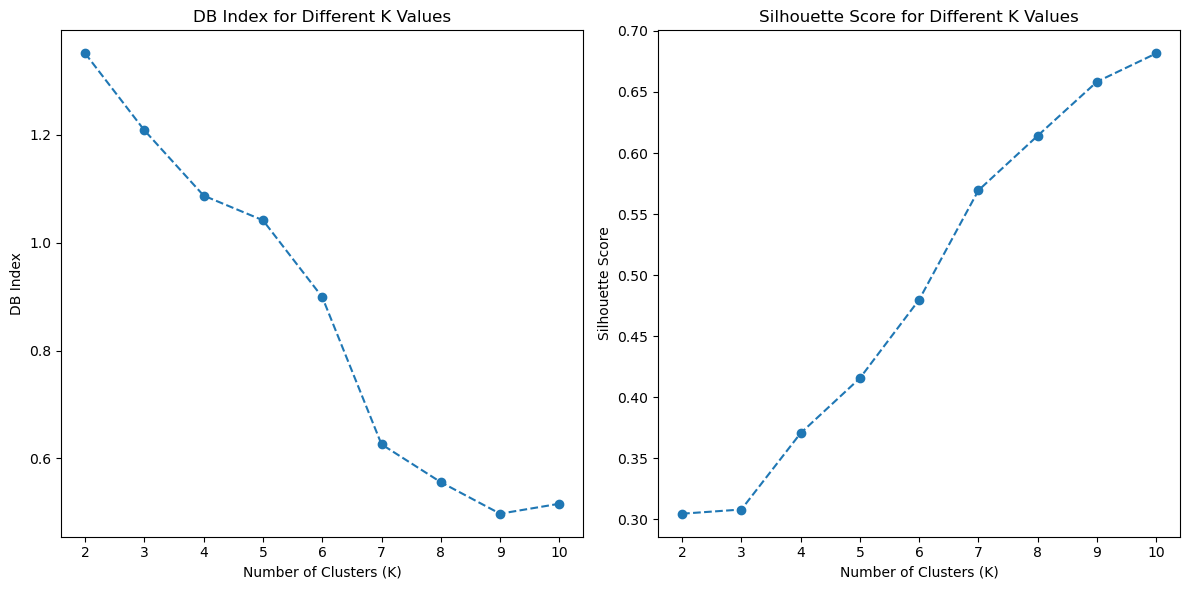

C:\Users\xdham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimal Number of Clusters: 3
DB Index: 1.2779638042542296
Silhouette Score: 0.33035951433470867


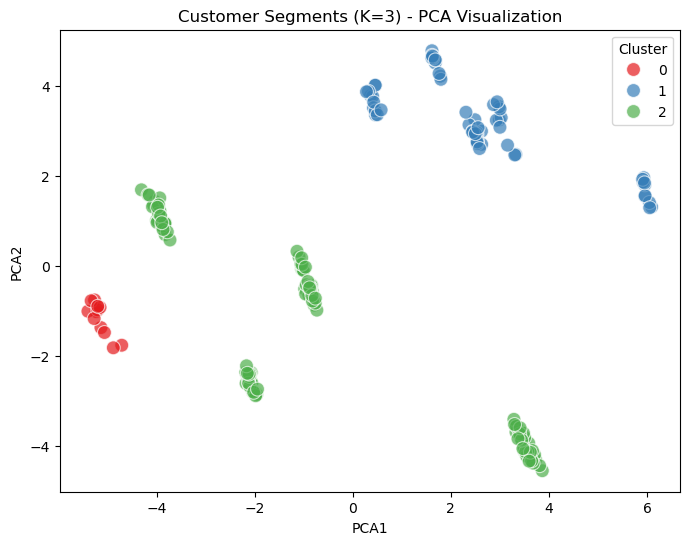

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv(r"C:\Users\xdham\Downloads\Customers.csv")
transactions = pd.read_csv(r"C:\Users\xdham\Downloads\Transactions.csv")

merged_data = transactions.merge(customers, on='CustomerID')

customer_profiles = merged_data.groupby('CustomerID').agg({
    'Region': 'first',
    'Price': 'mean',
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'SignupDate': 'first'
}).reset_index()

customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])
customer_profiles['TenureDays'] = (pd.to_datetime('today') - customer_profiles['SignupDate']).dt.days

customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

scaler = StandardScaler()
numerical_features = ['Price', 'TotalValue', 'Quantity', 'TenureDays']
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

dbi_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profiles[numerical_features + list(customer_profiles.columns[5:])])
    customer_profiles[f'Cluster_{k}'] = kmeans.labels_
    
    dbi = davies_bouldin_score(customer_profiles[numerical_features + list(customer_profiles.columns[5:])], kmeans.labels_)
    silhouette = silhouette_score(customer_profiles[numerical_features + list(customer_profiles.columns[5:])], kmeans.labels_)
    
    dbi_scores.append(dbi)
    silhouette_scores.append(silhouette)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, dbi_scores, marker='o', linestyle='--')
plt.title('DB Index for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('DB Index')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

optimal_k = 3
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(customer_profiles[numerical_features + list(customer_profiles.columns[5:])])
customer_profiles['Cluster'] = kmeans_optimal.labels_

dbi_optimal = davies_bouldin_score(customer_profiles[numerical_features + list(customer_profiles.columns[5:])], customer_profiles['Cluster'])
silhouette_optimal = silhouette_score(customer_profiles[numerical_features + list(customer_profiles.columns[5:])], customer_profiles['Cluster'])

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"DB Index: {dbi_optimal}")
print(f"Silhouette Score: {silhouette_optimal}")

pca = PCA(n_components=2)
principal_components = pca.fit_transform(customer_profiles[numerical_features + list(customer_profiles.columns[5:])])

customer_profiles['PCA1'] = principal_components[:, 0]
customer_profiles['PCA2'] = principal_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_profiles, palette='Set1', s=100, alpha=0.7)
plt.title(f'Customer Segments (K={optimal_k}) - PCA Visualization')
plt.show()

customer_profiles.to_csv('Customer_Segmentation.csv', index=False)
